# TES2025 Workshop 3 - Satellite Data Analysis for Urban Expansion with Python

## 5. Land Use Land Cover Classification

Congratulations, If your are here you know most common things about remote sensing or observation satellite already.

Most of operations in RS and Geograpgy guys are about to classify land types by visual or machine interpreration.

This section is a major part of the workshop. This is about to do LULC classification, but we are more advanced to do Machine Learning algorithm to recognize land types. Let's get started

In [1]:
!pip install pystac_client planetary_computer geopandas rich rasterio matplotlib seaborn tabulate scikit-learn fiona tqdm mapclassify

import pystac_client
import planetary_computer

import geopandas as gpd
import rasterio

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from rasterio.transform import from_bounds
from rasterio.mask import mask
import fiona
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.1 MB/s eta 0:00:00


Get started form defining what are the data we need to query for image dataset.

In [2]:
STAC_URL = 'https://planetarycomputer.microsoft.com/api/stac/v1'

image_collection = 'landsat-c2-l2'

area_of_interest = [98.919831,18.754418,99.049607,18.819261]

max_cloud_percentage = 30

This section is for functionalities to reduce redundancy of coding and simplifying diffucult part focusing only nescessary.

In [3]:
# Define Data query

# Call STAC connection
def sign_in_and_get_collections(stac_url, collection_name, bbox, date_range, max_cloud_perc=30):
    catalog = pystac_client.Client.open(
                        stac_url,
                        modifier=planetary_computer.sign_inplace,
                        )
    return catalog.search(collections=[collection_name],
                        bbox=bbox,
                        datetime=date_range,
                        query={"eo:cloud_cover": {"lt": max_cloud_perc}}).item_collection()


def make_collection_table(items):
    return gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

def get_preview(item):

    preview_asset_name = 'rendered_preview'

    with rasterio.open(item.assets[preview_asset_name].href) as src:

        return src.read()

def get_datacube(item, asset_name_list=['blue', 'green', 'red'], aoi_file=None):

    np_array_list = []

    if aoi_file:
        aoi_gdf = gpd.read_file(aoi_file)
        geometry = [aoi_gdf.union_all()]

    for asset_name in asset_name_list:

        with rasterio.open(item.assets[asset_name].href) as src:

            if aoi_file:
                out_image, out_transform = rasterio.mask.mask(src, geometry, crop=True)
                metadata = src.meta

                metadata.update({"driver": "GTiff",
                                "height": out_image.shape[1],
                                "width": out_image.shape[2],
                                "transform": out_transform})
                np_array_list.append(out_image)

            else:
                np_array_list.append(src.read())



    return np.vstack(np_array_list).transpose(1,2,0), metadata

def get_training_data_by_points(reference_data_url, stac_item, bands=['blue', 'green', 'red']):

    def sample_raster_values(raster, points):
        with rasterio.open(raster) as src:
            values = []
            for point in points:
                #print(point)
                coords = (point.x, point.y)
                value = list(src.sample([coords]))[0][0]
                values.append(value)
        return values

    training_points = gpd.read_file(reference_data_url)

    for asset_name in bands:
        training_points[asset_name] =  sample_raster_values(stac_item.assets[asset_name].href, training_points.geometry)

    return training_points

def colorize_map(map_data, color_config):

    height, width = map_data.shape

    color_map = np.zeros(shape=(3, height, width)).astype(np.uint8)

    for i in tqdm(range(map_data.shape[0])):

        for j in range(map_data.shape[1]):

            color_map[:, i, j] = color_config[map_data[i, j]]

    return color_map


def save_array_as_tif(image_data, metadata, output_tif_path):

    if len(image_data.shape) == 2:
        metadata.update({"driver": "GTiff",
                        "height": image_data.shape[0],
                        "width": image_data.shape[1],
                        "dtype": image_data.dtype})

        image_data = image_data[np.newaxis, :, :]

    elif len(image_data.shape) == 3:
        metadata.update({"driver": "GTiff",
                        "count": image_data.shape[0],
                        "height": image_data.shape[1],
                        "width": image_data.shape[2],
                        "dtype": rasterio.uint8})
    else:
        raise AssertionError("Invalid image shape")

    # Save the clipped raster
    with rasterio.open(output_tif_path, "w", **metadata) as dest:

        if len(image_data.shape) == 3:

            for band in range(image_data.shape[0]):
                dest.write(image_data[band, :, :], band+1)
        else:

            dest.write(image_data[:, :], 1)


    print(f"Clipped raster saved to {output_tif_path}")



Now all ingradients are ready to be cooked.

First of all, as we did, we use STAC to request for dataset query for year 2014 and 2024 in order to select a pair of dataset to study LULC classification

__IF FOUND BROKEN PIPELINE ERROR, RUN THIS CELL AGAIN__

In [4]:
print(f'======================= Before Change COLLECTION ==================== \n')

items_2014 = sign_in_and_get_collections(stac_url = STAC_URL,
                        collection_name = image_collection,
                        bbox = area_of_interest,
                        date_range= "2019-01-01/2019-12-31",
                        max_cloud_perc=max_cloud_percentage)

print(make_collection_table(items_2014).drop("geometry", axis='columns').to_markdown())

print(f'\n\n')

print(f'======================= AFTER Change COLLECTION ==================== \n')
items_2024 = sign_in_and_get_collections(stac_url = STAC_URL,
                        collection_name = image_collection,
                        bbox = area_of_interest,
                        date_range= "2024-01-01/2024-12-31",
                        max_cloud_perc=max_cloud_percentage)

print(make_collection_table(items_2024).drop("geometry", axis='columns').to_markdown())

======================= Before Change COLLECTION ==================== 

|    |   gsd | created                     | sci:doi          | datetime                    | platform   |   proj:epsg | proj:shape   | description                  | instruments     |   eo:cloud_cover | proj:transform                               |   view:off_nadir |   landsat:wrs_row | landsat:scene_id      |   landsat:wrs_path |   landsat:wrs_type |   view:sun_azimuth | landsat:correction   |   view:sun_elevation |   landsat:cloud_cover_land |   landsat:collection_number | landsat:collection_category   |
|---:|------:|:----------------------------|:-----------------|:----------------------------|:-----------|------------:|:-------------|:-----------------------------|:----------------|-----------------:|:---------------------------------------------|-----------------:|------------------:|:----------------------|-------------------:|-------------------:|-------------------:|:---------------------|---------------

As above, there are many list of datasets that may confuse us which one should be used.

The index of selected data below helps us (pre-selected). If you want to explore more images, you can check the list of images above and put the index of selection below

In [5]:
item_select_2014 = 2
item_select_2024 = 19

This step will show preview of images selected. If we change any index of data, run the below code again to preview the data

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


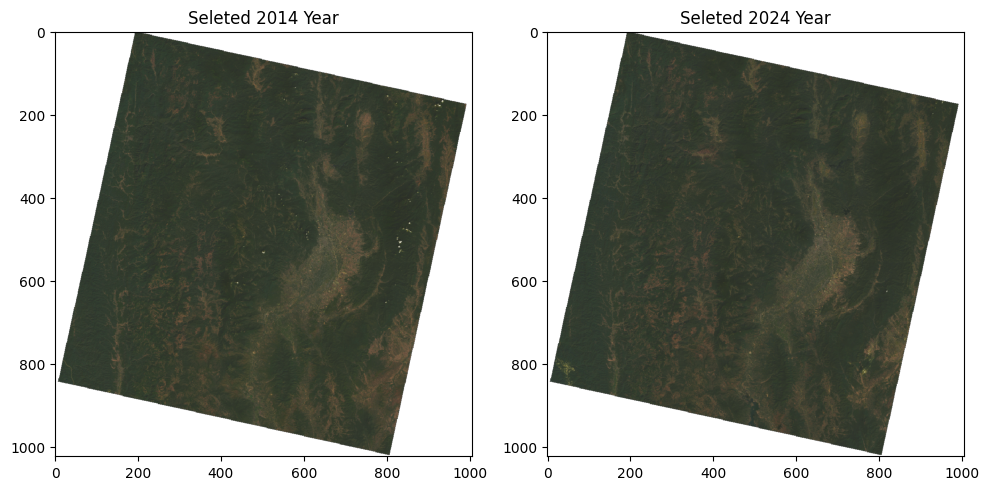

In [6]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

axs[0].imshow(get_preview(items_2014[item_select_2014]).transpose(1,2,0))
axs[0].set_title('Seleted 2014 Year')

axs[1].imshow(get_preview(items_2024[item_select_2024]).transpose(1,2,0))
axs[1].set_title('Seleted 2024 Year')

fig.tight_layout()
fig.show()

However, selected data is based on least cloud cover in same period and tile. Please be noted that there should be same tile bounds and nearby period to reduce unexpected result effect (e.g. different season etc.)

### Training Land cover classification model

Before going to do LULC classification using Machine Learning model. We should declare some useful properties for better intuition further

In [7]:
select_spectral_bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
color_spectral_bands =['blue', 'lightgreen', 'red', 'darkred', 'gray', 'black']

y_name = {
    0: 'Unclassified',
    10: 'Vegetation',
    20: 'Shrubland',
    30: 'Grassland',
    40: 'Cropland',
    50: 'Built-up',
    60: 'Bareland',
    80: 'Water body'
}

y_color = [
    'black',
    'green',
    'orange',
    'yellow',
    'magenta',
    'red',
    'lightgrey',
    'blue'
]

lulc_color = {
    0: (0, 0, 0),
    10: (1, 128, 1),
    20: (255, 165, 1),
    30: (255, 255, 1),
    40: (255, 1, 255),
    50: (255, 1, 1),
    60: (204, 204, 204),
    80: (1, 1, 255)
}

In [8]:
training_points = 'https://raw.githubusercontent.com/thanthamky/tes-urban/refs/heads/main/training_points.geojson'

points_gdf = gpd.read_file(training_points)

points_gdf.explore(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                   attr='Google Satellite Hybrd',)

Now, below code is ready to run. this performs useing points to extract spectral infomation from various bands defined above. Points are sparsed around study area with LULC labels for training the model. It takes some a few minutes get the dataset

In [9]:
dataset_df = get_training_data_by_points(reference_data_url = 'https://raw.githubusercontent.com/thanthamky/tes-urban/refs/heads/main/training_points.geojson',
                            stac_item = items_2014[item_select_2024],
                            bands = select_spectral_bands)

Check the dataset here. You may consider it is a DataFrame of training data. Records are each point location, and they have value DN values for all specified bands

In [10]:
dataset_df.loc[:, ['class_name', 'class1']+select_spectral_bands]

class_name  class1  blue  green    red  nir08  swir16  swir22
0       Built-up      50  9723  10900  11307  13677   13488   12386
1     Vegetation      10  8660   9529   9395  16078   13134   11140
2     Vegetation      10  9360  10699  11418  15599   16492   13997
3     Vegetation      10  8287   9096   9048  16102   13448   10315
4     Vegetation      10  7727   8419   7945  17872   10935    8693
...          ...     ...   ...    ...    ...    ...     ...     ...
5346  Vegetation      10  9277   9975   9953  16141   14302   11970
5347  Vegetation      10  8785   9553   9392  17299   13770   10624
5348  Vegetation      10  9939  10468  10394  15352   15189   13139
5349  Vegetation      10  9120   9756   9567  15801   13509   11125
5350    Cropland      40  9415  10431  10426  17775   16512   13001

[5351 rows x 8 columns]

However, there are some point that unable to extract due to none-value in that coordinates of satellite image (e.g. out of bounds). we can filter them to __Unclassified__ class for more robust in actual traininig.

In [11]:
dataset_df.loc[dataset_df['nir08'] == 0, 'class1'] = 0
dataset_df.loc[dataset_df['nir08'] == 0, 'class_name'] = 'Unclassified'

dataset_df

rand_point_id  class1  class_name                        geometry  blue  \
0                 0      50    Built-up   POINT (506804.64 2078222.051)  9723   
1                 1      10  Vegetation  POINT (513873.809 2090669.093)  8660   
2                 2      10  Vegetation  POINT (515665.318 2091346.788)  9360   
3                 3      10  Vegetation  POINT (528992.431 2103531.176)  8287   
4                 4      10  Vegetation  POINT (534679.876 2109160.968)  7727   
...             ...     ...         ...                             ...   ...   
5346           5346      10  Vegetation   POINT (499621.97 2066309.964)  9277   
5347           5347      10  Vegetation   POINT (501653.783 2070783.27)  8785   
5348           5348      10  Vegetation   POINT (498789.872 2060700.84)  9939   
5349           5349      10  Vegetation  POINT (504298.537 2065342.187)  9120   
5350           5350      40    Cropland  POINT (500706.039 2069412.155)  9415   

      green    red  nir08  swir16  swir22  
0     10900  11307  13677   13488   12386  
1      9529   9395  16078   13134   11140  
2     10699  11418  15599   16492   13997  
3      9096   9048  16102   13448   10315  
4      8419   7945  17872   10935    8693  
...     ...    ...    ...     ...     ...  
5346   9975   9953  16141   14302   11970  
5347   9553   9392  17299   13770   10624  
5348  10468  10394  15352   15189   13139  
5349   9756   9567  15801   13509   11125  
5350  10431  10426  17775   16512   13001  

[5351 rows x 10 columns]

Our data is ready to analysis. Go through common ML guy to do. Defining X and y

In [12]:
X = dataset_df.loc[:, select_spectral_bands]
y = dataset_df.loc[:, 'class1']

You may question it what is X

In [13]:
X

blue  green    red  nir08  swir16  swir22
0     9723  10900  11307  13677   13488   12386
1     8660   9529   9395  16078   13134   11140
2     9360  10699  11418  15599   16492   13997
3     8287   9096   9048  16102   13448   10315
4     7727   8419   7945  17872   10935    8693
...    ...    ...    ...    ...     ...     ...
5346  9277   9975   9953  16141   14302   11970
5347  8785   9553   9392  17299   13770   10624
5348  9939  10468  10394  15352   15189   13139
5349  9120   9756   9567  15801   13509   11125
5350  9415  10431  10426  17775   16512   13001

[5351 rows x 6 columns]

Actually, it is no point to convert the DN into reflectance because they are all same scale already (int16 bits). If you prefer to see actual scale of reflectance, you may run this

In [14]:
calc_reflectance = lambda dn: dn * 0.0000275 - 0.2

In [15]:
X_ref = calc_reflectance(X)
X_ref[X_ref < 0] = 0

X_ref

blue     green       red     nir08    swir16    swir22
0     0.067383  0.099750  0.110942  0.176117  0.170920  0.140615
1     0.038150  0.062047  0.058362  0.242145  0.161185  0.106350
2     0.057400  0.094222  0.113995  0.228973  0.253530  0.184918
3     0.027892  0.050140  0.048820  0.242805  0.169820  0.083662
4     0.012492  0.031523  0.018487  0.291480  0.100712  0.039057
...        ...       ...       ...       ...       ...       ...
5346  0.055117  0.074313  0.073707  0.243878  0.193305  0.129175
5347  0.041587  0.062707  0.058280  0.275722  0.178675  0.092160
5348  0.073323  0.087870  0.085835  0.222180  0.217697  0.161322
5349  0.050800  0.068290  0.063092  0.234527  0.171498  0.105938
5350  0.058912  0.086852  0.086715  0.288813  0.254080  0.157527

[5351 rows x 6 columns]

And This is y

In [16]:
y

0       50
1       10
2       10
3       10
4       10
        ..
5346    10
5347    10
5348    10
5349    10
5350    40
Name: class1, Length: 5351, dtype: int32

Stop here, as the data scientist, we won't skip this part. Exploratory Data Analysis (EDA), making some understanding first. At least, there should spectral histrogram to understand reflectance nature of each LULC

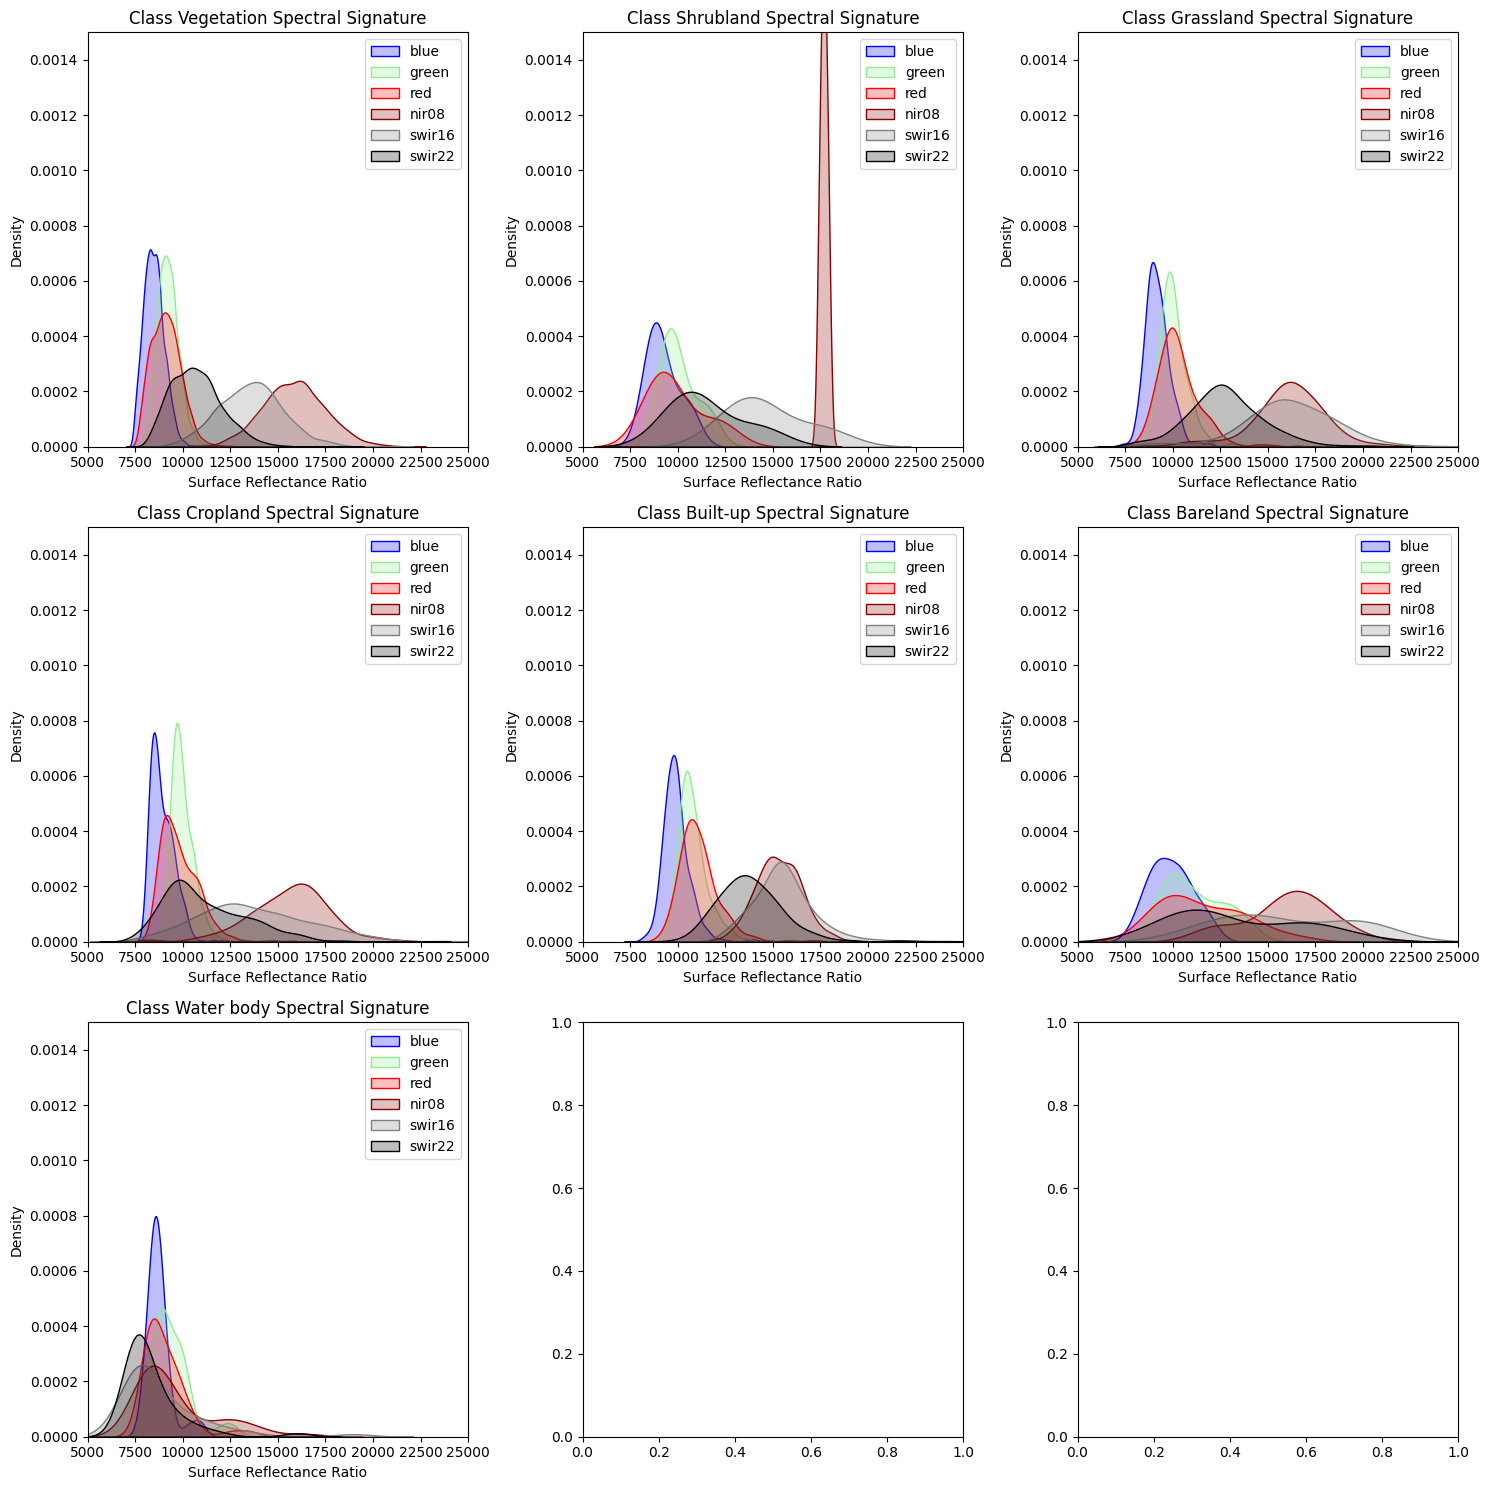

In [17]:
y_list = np.unique(y)

fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.ravel()

for axs_idx, y_class in enumerate(y_list):

    if y_class == 0: continue

    # Example NumPy array
    data = X[y == y_class]

    for band_idx, (band, color) in enumerate(zip(select_spectral_bands, color_spectral_bands)):
        sns.kdeplot(data.iloc[:, band_idx], fill=True, color=color, label=band, ax=axs[axs_idx])


    axs[axs_idx].set_title(f'Class {y_name[y_class]} Spectral Signature')

    axs[axs_idx].set_ylabel('Density')
    axs[axs_idx].set_xlabel('Surface Reflectance Ratio')

    axs[axs_idx].set_xlim(5_000, 25_000)
    axs[axs_idx].set_ylim(0, 0.0015)

    axs[axs_idx].legend()

fig.tight_layout()
fig.show()

Not only histogram, there should be some spectral signature visualization. It helps us to consider spectral similarity.

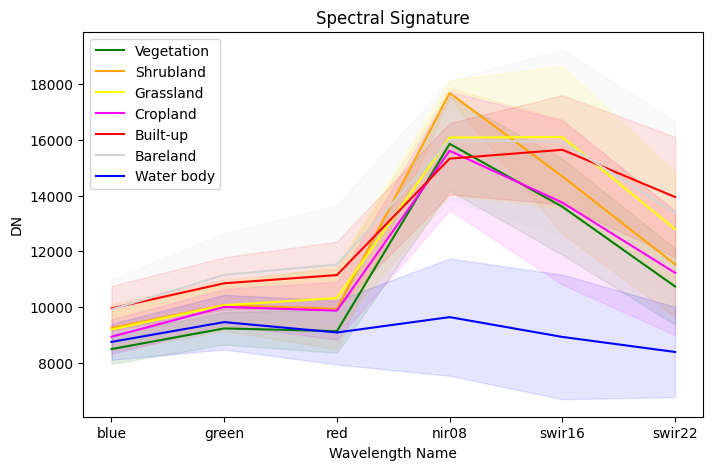

In [18]:
y_list = np.unique(y)

plt.figure(figsize=(8, 5))

for color, name in zip(y_color, y_name.items()):

    if name[0] == 0: continue

    data = X[y == name[0]]
    #data = X_ref[y == name[0]]

    means = data.mean(axis=0)
    stds = data.std(axis=0)

    upper_bound = means + stds
    lower_bound = means - stds

    plt.plot(means, color=color, label=name[1])
    plt.fill_between(np.arange(len(means)), upper_bound, lower_bound, alpha=.1, color=color)

plt.legend()
plt.title('Spectral Signature')
plt.xlabel('Wavelength Name')
plt.ylabel('DN')
#plt.ylabel('Reflectance')

plt.show()

Until this step, there are some problems we recognize. Since LULC class labels are just very small differences. This encourage us to prove that this complicated features should be dealed with ML algorithms. Now, it is time for ML. First of all, prepare the ingradients again but for ML tasks

## Model Training

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

Inject Unclassified class

In [20]:
X = np.vstack([X, np.asarray([[0]*X.shape[1]]*100)])
y = np.hstack([y.values, np.asarray([0]*100)])

Because the DN is a big scale of values ranging in int16 bit quantization. we should employ __Scaler__ to rescale the DN in to proper range using __MinMaxScaler__. You may know about __StandardScaler__ you can try!!

In [21]:
scaler = MinMaxScaler()
#scaler = StandardScaler()

scaler.fit(X)

X_scale = scaler.transform(X)

How does it scale? check it by box plot

<ipython-input-22-3ad8d7500dbc>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X_scale, labels=[f"Col {i+1}" for i in range(data.shape[1])])


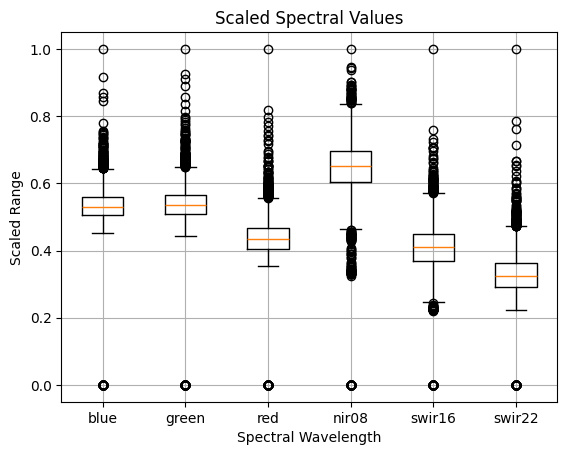

In [22]:
# Create the box plot
plt.boxplot(X_scale, labels=[f"Col {i+1}" for i in range(data.shape[1])])

# Add labels and title
plt.xlabel("Spectral Wavelength")
plt.ylabel("Scaled Range")
plt.title("Scaled Spectral Values")

# Show the plot
plt.xticks(np.arange(1, X_scale.shape[1]+1), select_spectral_bands)

plt.grid()
plt.show()

Next is modeling part, to be proper robustness, split the data into training and testing set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, stratify=y)

Check the number of training and testing

In [24]:
print('Training shape: ', X_train.shape, y_train.shape)
print('Testing shape: ', X_test.shape, y_test.shape)

Training shape:  (4088, 6) (4088,)
Testing shape:  (1363, 6) (1363,)


Select one of models. This default is __Random Forest__. You may use __SVM__ (SVC) instead to experiment

In [25]:
#model = SVC()
model = RandomForestClassifier(n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

After the training, It may very fast to learn the problem. Testing some of metrics to evaluate the model

In [26]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3, zero_division=0))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        25
          10      0.869     0.958     0.911       971
          20      0.000     0.000     0.000         1
          30      0.435     0.132     0.202        76
          40      0.680     0.540     0.602       161
          50      0.725     0.687     0.705       115
          60      0.000     0.000     0.000         4
          80      0.625     0.500     0.556        10

    accuracy                          0.833      1363
   macro avg      0.542     0.477     0.497      1363
weighted avg      0.808     0.833     0.814      1363



The first result you may not satistfied, but trust me, it is normal. It is common problem of unnbalanced samples that the model has bias on more samples because they have more diversity to discrimination. Not satisfying?, yes, try different way of __GridSearchCV__. It implement multi-experiments to find out which combination sets is the best for this problem. Try __GridSearchCV__ for __RandomForestClassifier__

![](https://miro.medium.com/v2/resize:fit:1400/1*N45hocCMP0u4nXLe0WuSvw.png)

The __GridsearchCV__ apply the __K-Fold__ validation method to split training data into _k_ subset. Fitting through all subsets with one testing set each outputs average performance score as the candidate of a particular combination of hyperparameter sets.

In [27]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up the GridSearchCV
model_rf_cv = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=3,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as the scoring metric
    verbose=2,  # Print progress during the search
    n_jobs=-1  # Use all available CPU cores
)

# Fit the model on the training data
model_rf_cv.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best Parameters:", model_rf_cv.best_params_)
print("Best Cross-Validation Score:", model_rf_cv.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.819961078916286


Try __SVC__?

In [28]:
param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization parameter
    'kernel': ['linear', 'rbf'],     # Kernels to try
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient
    'degree': [2, 3, 4],             # Only relevant for 'poly' kernel
}

# Set up GridSearchCV
model_svm_cv = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=3,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit the model on the training data
model_svm_cv.fit(X_train, y_train)

# Display the best parameters and the best score
print("Best Parameters:", model_svm_cv.best_params_)
print("Best Cross-Validation Score:", model_svm_cv.best_score_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8373292264730884


Noted that there is no best combination of every case. The best combination is based on specific problem from given dataset, study area, label quality, stellite type etc. We should consider the robustness on Precision, Recall or F1-Score rather a single Accuracy

## Inferencing

Mode training is to let the model learn, but actual end of the story is to implement the trained model in real usage.
Model inference is a pipeline or process to let the model predict all of pixels within the selected scene in order to gather LULC Map in the study area

In [29]:
aoi_file = 'https://raw.githubusercontent.com/thanthamky/tes-urban/refs/heads/main/aoi.geojson'

Above cell is URL of aoi file. we can explore the interactive map by below code. Noted that this file is GEOJSON format. It may requires a bit GIS skill to produced it. If needed more tutorial. You can contact instructor!

In [30]:
aoi_df = gpd.read_file(aoi_file)

aoi_df.explore()

Now, it is time for inferencing the map. first of all, we need to retrieve all the pixels from images in study area. Run this

In [31]:
#X_2014 = get_datacube(items_2014[item_select_2014], select_spectral_bands)
X_2024, metadata = get_datacube(items_2024[item_select_2024],
                      select_spectral_bands,
                      aoi_file='https://raw.githubusercontent.com/thanthamky/tes-urban/refs/heads/main/aoi.geojson')

The `X` variable is a datacube of image shape Height, Width, and Bands.

In [32]:
X_2024.shape

(1901, 2293, 6)

We can easily implement previous know how to reshape and scale the data. The reshape is flatten the height and width of iamge into a single row of samples which the model understands what are they

In [33]:
inf_shape = X_2024.shape
X_2024_scale = scaler.transform(X_2024.reshape(-1, inf_shape[2]))

Run this to predict the LULC Map!!

In [34]:
y_2024 = model.predict(X_2024_scale)

# try model_rf_cv or model_svm_cv for different results

After prediction, we reshape the flattened the result back to original height and width

In [35]:
y_2024_reshape = y_2024.reshape(inf_shape[:2])

Declare the color map of each LULC

In [36]:
from matplotlib import colors

cmap = colors.ListedColormap(y_color)
bounds= list(y_name.keys())
norm = colors.BoundaryNorm(bounds, cmap.N)

Obtained result is simply numpy cube of image that can plot into by `matplotlib`

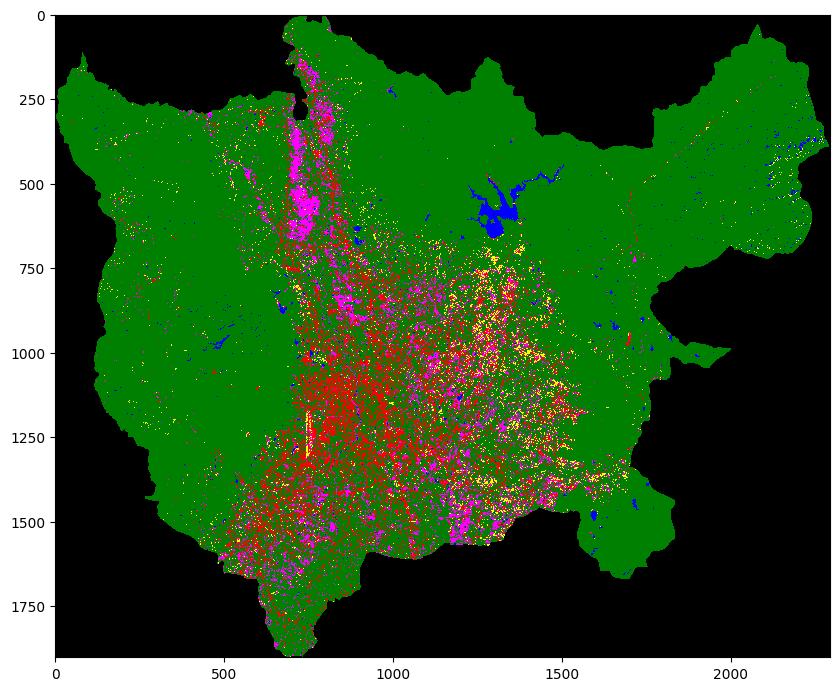

In [37]:
from matplotlib.colors import ListedColormap

color_map = ListedColormap(y_color)

plt.figure(figsize=(10,10))
plt.imshow(y_2024_reshape, interpolation='nearest', cmap=cmap, norm=norm)
plt.show()

We can save the result by this function

In [38]:
# Example usage
save_array_as_tif(y_2024_reshape, metadata, 'lulc_city_rf_2024.tif')

Clipped raster saved to lulc_city_rf_2024.tif


Do not forget that the image we did is just 2024 period. we have another 2014 period to perform

In [39]:
# Get the Inferencing input datacube
X_2014, metadata_2014 = get_datacube(items_2014[item_select_2014],
                      select_spectral_bands,
                      aoi_file='https://raw.githubusercontent.com/thanthamky/tes-urban/refs/heads/main/aoi.geojson')

# Transform the datacube (Scaling) and reshape to predictable form
inf_shape = X_2014.shape
X_2014_scale = scaler.transform(X_2014.reshape(-1, inf_shape[2]))

# Do prediction
y_2014 = model.predict(X_2014_scale)

# Reshape output like input shape (map dimension)
y_2014_reshape = y_2014.reshape(inf_shape[:2])

# Save output
save_array_as_tif(y_2014_reshape, metadata_2014, 'lulc_city_rf_2014.tif')

Clipped raster saved to lulc_city_rf_2014.tif


Preview the result of 2014 LULC map

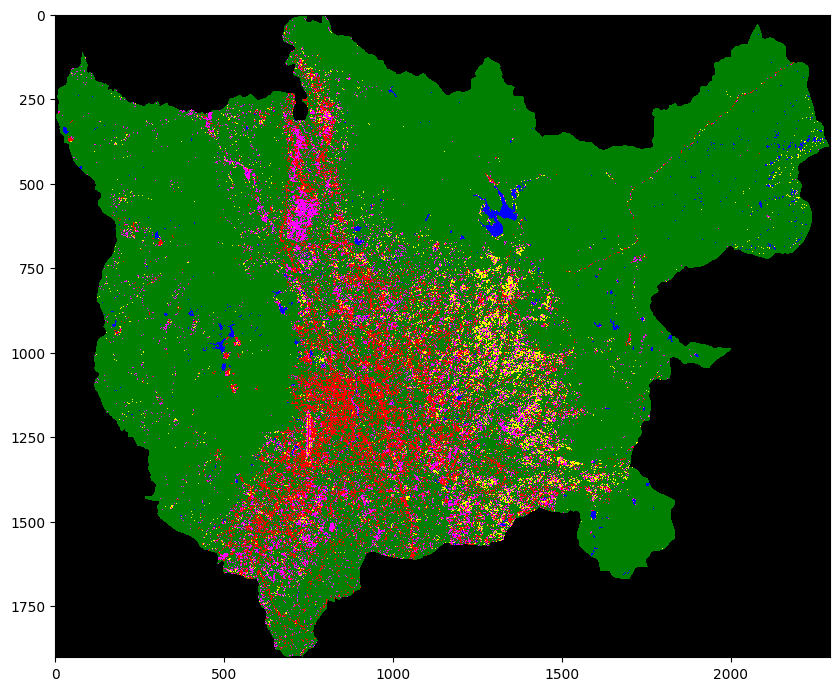

In [40]:
from matplotlib.colors import ListedColormap

color_map = ListedColormap(y_color)

plt.figure(figsize=(10,10))
plt.imshow(y_2014_reshape,  interpolation='nearest', cmap=cmap, norm=norm)
plt.show()

Compare the results between 2014 and 2024

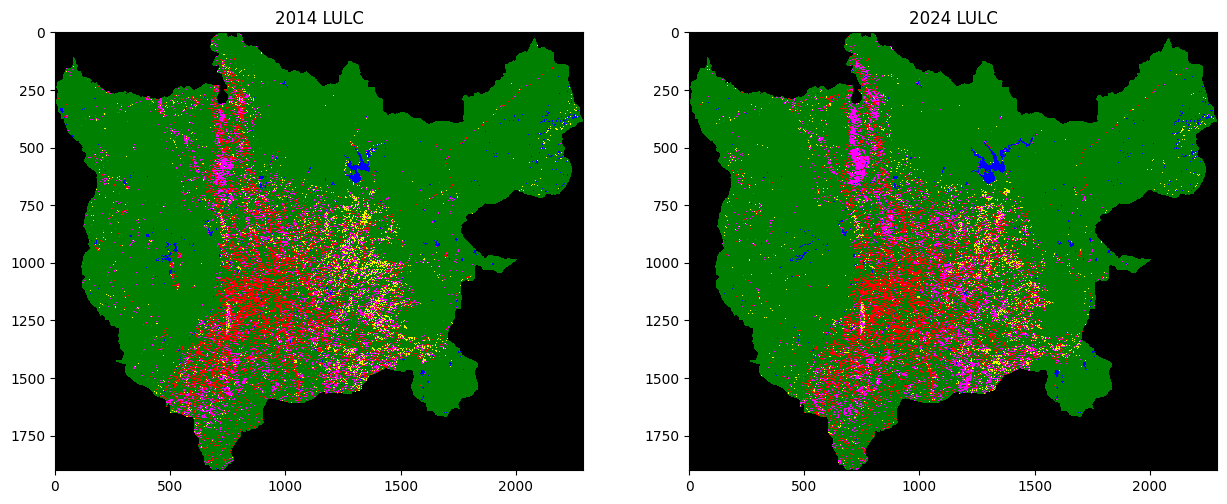

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))

ax[0].imshow(y_2014_reshape, interpolation='nearest', cmap=cmap, norm=norm)
ax[0].set_title('2014 LULC')

ax[1].imshow(y_2024_reshape, interpolation='nearest', cmap=cmap, norm=norm)
ax[1].set_title('2024 LULC')

fig.show()

Don't be exhausted, we have another interesting part. What we have done is to study the past to the present. How about the future?

## 6. Urban Land Classification and Area Analysis

Knowing future projection is important as well as current changes. This workshop will bring you through Spatial Analysis modeling named __Cellular Automata__ model which consider spatial movement of LULC changes based on given transition condition or probabilities.

In [42]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

np.set_printoptions(suppress=True, precision=3)

Ingradients of this analysis are LULC map files of both periods (2014 and 2024). before that, there are some functionalities to reduce complexity of coding that unnecessary to know about it.

![](https://miro.medium.com/v2/resize:fit:437/1*SUUir-VGHy2OFqbpKxwuJA.png)

When applyig the __Markov Chain__ transitions, the process to do __Cellular Automata__ employ the change simulation step-by-step using referenced trasition map

![](https://www.researchgate.net/publication/343335423/figure/fig4/AS:919266475900928@1596181615090/Procedure-to-predict-land-cover-change-from-CA-Markov-Chain-Kim-et-al-2014.png)


In [43]:


def align_rasters(src_path1, src_path2):
    """Align two raster files to the same shape, resolution, and CRS."""

    with rasterio.open(src_path1) as src1, rasterio.open(src_path2) as src2:

        # Calculate the intersection of the extents
        left = max(src1.bounds.left, src2.bounds.left)
        bottom = max(src1.bounds.bottom, src2.bounds.bottom)
        right = min(src1.bounds.right, src2.bounds.right)
        top = min(src1.bounds.top, src2.bounds.top)
        intersect_bounds = (left, bottom, right, top)

        # Define a new transform and shape based on intersection
        transform, width, height = calculate_default_transform(
            src1.crs, src1.crs, src1.width, src1.height, *intersect_bounds
        )

        # Align the first raster
        aligned1 = np.empty((height, width), dtype=src1.meta['dtype'])
        reproject(
            source=rasterio.band(src1, 1),
            destination=aligned1,
            src_transform=src1.transform,
            src_crs=src1.crs,
            dst_transform=transform,
            dst_crs=src1.crs,
            resampling=Resampling.nearest,
        )

        # Save aligned raster 1
        profile = src1.profile

        # Align the second raster
        aligned2 = np.empty((height, width), dtype=src2.meta['dtype'])
        reproject(
            source=rasterio.band(src2, 1),
            destination=aligned2,
            src_transform=src2.transform,
            src_crs=src2.crs,
            dst_transform=transform,
            dst_crs=src1.crs,
            resampling=Resampling.nearest,
        )

    return aligned1, aligned2, profile

def calculate_transition(datacube_past, datacube_current):

    # Flatten arrays and calculate transition matrix
    transitions = confusion_matrix(datacube_past.flatten(), datacube_current.flatten(), normalize='true')


    return transitions

def modify_transition_matrix(transitions):

    ts = transitions.transpose()

    class_sum = transitions.sum(axis=0)

    transitions = np.asarray([ts[i] / class_sum[i] for i in range(len(ts))])

    return transitions


We call the LULC map files from preivous saves. Nevertheless, some preople may not be convinient to perform locally. we prepared the file on the cloud

In [44]:

# Paths to your raster files
raster_past_path = 'https://github.com/thanthamky/tes-urban/raw/refs/heads/main/lulc_city_rf_2014.tif'
raster_current_path = 'https://github.com/thanthamky/tes-urban/raw/refs/heads/main/lulc_city_rf_2024.tif'

# Align rasters
datacube_past, datacube_current, raster_profile = align_rasters(raster_past_path, raster_current_path)

# Calculate transition matrix
transitions = calculate_transition(datacube_past, datacube_current)

Originally, the transition matrix is simply counts of one state to another, divided by sum of referecenes.

In [45]:
transitions

array([[1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.923, 0.   , 0.028, 0.013, 0.035, 0.001],
       [0.   , 0.479, 0.   , 0.171, 0.085, 0.256, 0.009],
       [0.   , 0.591, 0.   , 0.28 , 0.063, 0.063, 0.002],
       [0.   , 0.544, 0.   , 0.159, 0.162, 0.128, 0.006],
       [0.   , 0.322, 0.   , 0.045, 0.04 , 0.591, 0.002],
       [0.   , 0.213, 0.   , 0.006, 0.014, 0.01 , 0.757]])

By the way, this might be not efficient since samples are not weighted because of unbalance. We modify the rules of the transition matrix to be more intuition.

In [46]:
transitions = modify_transition_matrix(transitions)

transitions

array([[1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.3  , 0.156, 0.192, 0.177, 0.105, 0.069],
       [0.   , 0.06 , 0.   , 0.447, 0.341, 0.152, 0.   ],
       [0.   , 0.04 , 0.248, 0.406, 0.231, 0.066, 0.008],
       [0.   , 0.034, 0.226, 0.168, 0.43 , 0.105, 0.037],
       [0.   , 0.033, 0.237, 0.058, 0.118, 0.546, 0.009],
       [0.   , 0.001, 0.011, 0.003, 0.008, 0.003, 0.974]])

Show the result of the transition matrix in numpy matrix is quite diffficult. Show it by plt

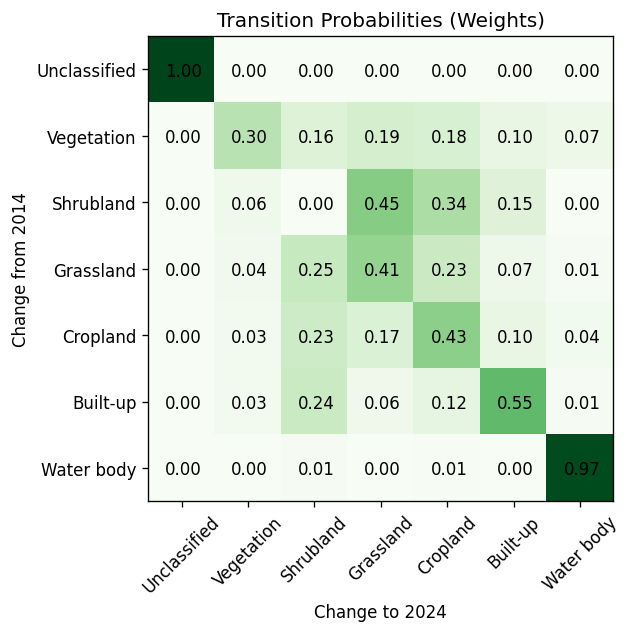

In [47]:
labels = [y_name[class_id] for class_id in np.unique(datacube_past).tolist()]

plt.figure(figsize=(5,9), dpi=120)

plt.imshow(transitions, cmap='Greens')

for i in range(transitions.shape[0]):

    for j in range(transitions.shape[1]):

        plt.text(j-0.25, i+0.1, f'{transitions[i, j]:.2f}')

plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.xlabel('Change to 2024')

plt.yticks(np.arange(len(labels)), labels)
plt.ylabel('Change from 2014')

plt.title('Transition Probabilities (Weights)')
plt.show()

Before implementing the transition weights, we need to transform the pixel values (from class-oriented) to encoder values (to index-oriented) for more convinient in searching weights. Also, most of function rely on single-dimension array.

In [48]:
encoder = LabelEncoder()

map_shape = datacube_current.shape

Encode the map data for both past state and current state

In [49]:
datacube_current_enc = encoder.fit_transform(datacube_current.flatten()).reshape(map_shape)
datacube_past_enc = encoder.transform(datacube_past.flatten()).reshape(map_shape)

This is oroginal class label

In [50]:
encoder.classes_

array([ 0, 10, 20, 30, 40, 50, 80], dtype=uint16)

And this is encoded label

In [51]:
np.unique(datacube_current_enc)

array([0, 1, 2, 3, 4, 5, 6])

Next is important, before go through __Cellular Automata Markov-Chain__ concept, plase go to simple example first in git `simple_ca-markov.ipynb` first.


<br>

If you already know about CA-Markov works. Simple conclusion is we need 2 essential steps to apply these to every pixel to simulate the transitions. Each pixel, we apply `get_neighbors` to gather the nearby pixel of target running pixel, then apply `update_cell`. This step is to calculate what is next state of the pixel should be. However, there are some different concept of updating pixel.


#### Argmax selection
![Argmax](https://www.sharpsightlabs.com/wp-content/uploads/2020/11/numpy-argmax-2D_axis-1.png)

- Next state selection is based on max probability of a rows of choices
- Too deterministic
- But more controllable
- Expectable state


#### Random choice selection

![](https://www.sharpsightlabs.com/wp-content/uploads/2019/06/np-random-choice-weighted-outcomes.png)

- Next state selectioj is based on random selection but every choice has beed weighted by transition probabilities.
- Randomness added
- Chaos but still predictable
- Decrease deterministic simulation


In [52]:
def update_map(current_datacube, transition_matrix, radius=1):

    NUM_CLASSES = len(np.unique(current_datacube))

    # Define a neighborhood kernel for cellular automata
    def get_neighbors(grid, x, y, radius=1):
        """
        Get the neighborhood values of a cell within a specified radius.
        Args:
            grid (numpy.ndarray): The grid.
            x (int): The row index of the cell.
            y (int): The column index of the cell.
            radius (int): The search radius (default is 1).
        Returns:
            numpy.ndarray: A flattened array of neighborhood values.
        """
        # Define the bounds of the neighborhood
        x_min = max(0, x - radius)
        x_max = min(grid.shape[0], x + radius + 1)
        y_min = max(0, y - radius)
        y_max = min(grid.shape[1], y + radius + 1)

        # Extract the neighborhood
        neighborhood = grid[x_min:x_max, y_min:y_max]

        return neighborhood.flatten()

    # Cellular Automata update function
    def update_cell(current_class, neighbors):
        """Update the cell class based on neighborhood influence and Markov transition."""
        class_counts = np.bincount(neighbors, minlength=NUM_CLASSES)
        influence = class_counts / class_counts.sum()

        # Combine neighborhood influence with Markov probabilities
        combined_probabilities = transition_matrix[current_class] * influence
        combined_probabilities /= combined_probabilities.sum()  # Normalize

        # Choose the new state based on probabilities
        return np.random.choice(np.arange(NUM_CLASSES), p=combined_probabilities)

        # argmax
        return np.argmax(combined_probabilities)

    next_datacube = np.copy(current_datacube)

    for i in tqdm(range(current_datacube.shape[0])):

        for j in range(current_datacube.shape[1]):

            neighbors = get_neighbors(current_datacube, i, j, radius=2)
            next_datacube[i, j] = update_cell(current_datacube[i, j], neighbors)

    return next_datacube

The pixel has beed updated once next state is selected. These operations iterate over the whole map data. we can get the next stete map. Try this

In [53]:
current_map = update_map(current_datacube=datacube_current_enc, transition_matrix=transitions, radius=2)

100%|██████████| 1901/1901 [03:33<00:00,  8.92it/s]


You may try with sider search pixel `radius=2` to some integer values to see how it becomes change

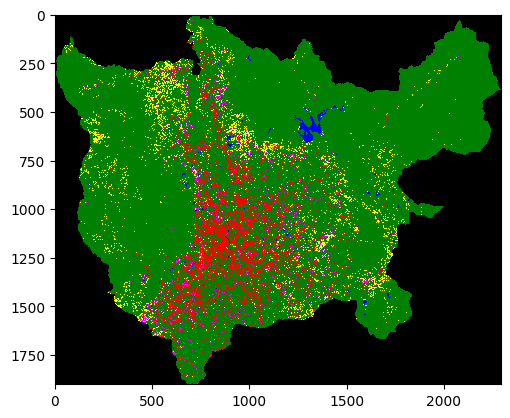

In [54]:
current_map_invenc = encoder.inverse_transform(current_map.flatten()).reshape(map_shape)

plt.imshow(current_map_invenc, interpolation='nearest', cmap=cmap, norm=norm)

If we have no problem, we try to do it `5` steps of simulations

In [55]:
simulation_step = 5

The process will also save the output as the visualizable map file `.tif` format in order to use it in next session

100%|██████████| 1901/1901 [00:14<00:00, 134.91it/s]


Clipped raster saved to lulc_city_camk_2024_3step_1_color.tif


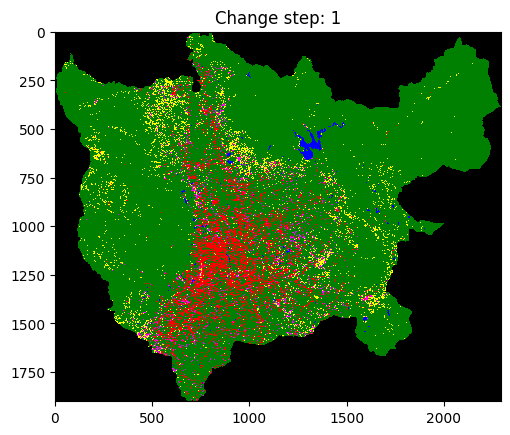

100%|██████████| 1901/1901 [00:14<00:00, 130.72it/s]


Clipped raster saved to lulc_city_camk_2024_3step_2_color.tif


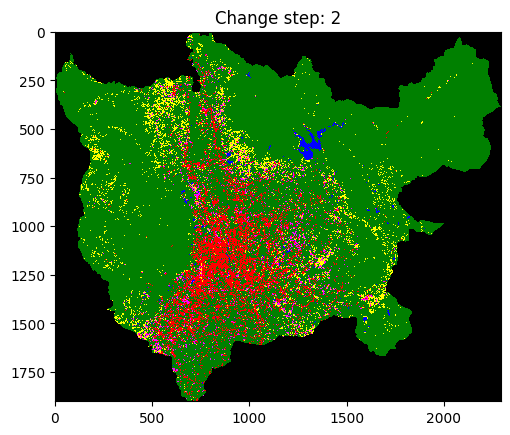

100%|██████████| 1901/1901 [00:14<00:00, 130.92it/s]


Clipped raster saved to lulc_city_camk_2024_3step_3_color.tif


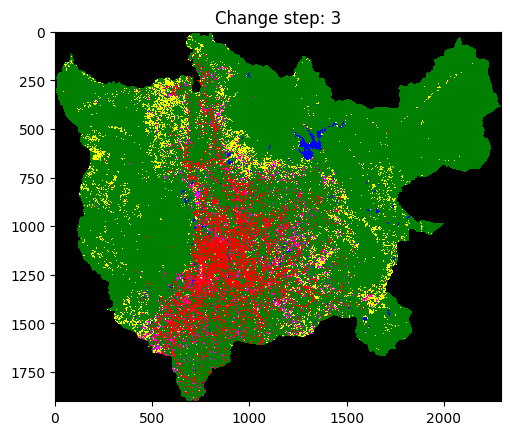

100%|██████████| 1901/1901 [00:14<00:00, 130.04it/s]


Clipped raster saved to lulc_city_camk_2024_3step_4_color.tif


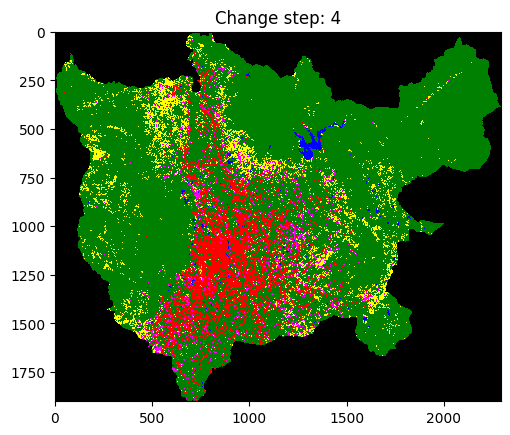

100%|██████████| 1901/1901 [00:14<00:00, 130.81it/s]


Clipped raster saved to lulc_city_camk_2024_3step_5_color.tif


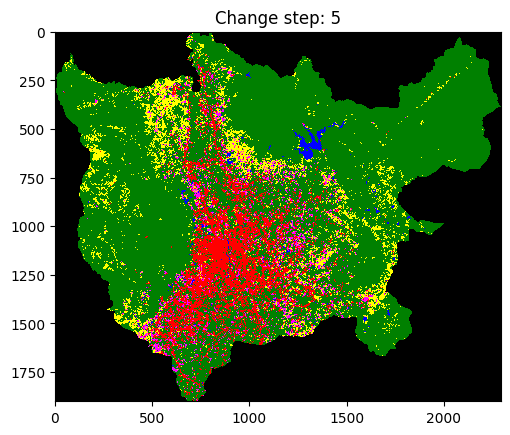

In [56]:
state_map = datacube_current_enc.copy()

for i in range(simulation_step):

    state_map = update_map(current_datacube=state_map, transition_matrix=transitions, radius=2)

    state_map_invenc = encoder.inverse_transform(state_map.flatten()).reshape(map_shape)

    state_map_invenc_color = colorize_map(state_map_invenc, lulc_color)

    save_array_as_tif(state_map_invenc_color, raster_profile, f'lulc_city_camk_2024_3step_{i+1}_color.tif')

    plt.title(f'Change step: {i+1}')
    plt.imshow(state_map_invenc, interpolation='nearest', cmap=cmap, norm=norm)
    plt.show()

Please be noted that this simulation step is depend on how leap the year is calculated. `2014` and `2024` are 10-year leap. So that, eahc step means 10-year simulation steps.

<br>

Next session is about visualization. We do not forget to export the colorized map files

In [57]:
save_array_as_tif(colorize_map(datacube_past, lulc_color), raster_profile, 'lulc_rf_2014_color.tif')
save_array_as_tif(colorize_map(datacube_current, lulc_color), raster_profile, 'lulc_rf_2024_color.tif')

100%|██████████| 1901/1901 [00:21<00:00, 86.94it/s] 


Clipped raster saved to lulc_rf_2014_color.tif


100%|██████████| 1901/1901 [00:14<00:00, 132.10it/s]

Clipped raster saved to lulc_rf_2024_color.tif


This step we have 3 maps already; past (2014), current (2024) and future+steps (2024 + {step*10}). We have to see the result of simulation by numeric and chart visuals.

In [58]:
lulc_area_table = []

lulc_area_table.append(np.unique(datacube_past_enc, return_counts=True)[1])
lulc_area_table.append(np.unique(datacube_current_enc, return_counts=True)[1])

lulc_area_table.append(np.unique(state_map_invenc, return_counts=True)[1])


Change through simualtion is this

In [59]:
lulc_area_df = pd.DataFrame(np.stack(lulc_area_table).transpose())

lulc_area_df

0        1        2
0  1839963  1839963  1839963
1  2258547  2200153  1897691
2      117      135       63
3    99911   100908   228253
4    31623    45512   100101
5   111339   155818   268877
6    17493    16504    24045

Decorate the table

In [60]:
lulc_area_df.columns = ['2014', '2024', f'2024+{simulation_step} steps']
lulc_area_df =  lulc_area_df.set_index([pd.Series(labels)])

lulc_area_df

2014     2024  2024+5 steps
Unclassified  1839963  1839963       1839963
Vegetation    2258547  2200153       1897691
Shrubland         117      135            63
Grassland       99911   100908        228253
Cropland        31623    45512        100101
Built-up       111339   155818        268877
Water body      17493    16504         24045

We know that is pixel-counts unit, and we know that __Landsat__ is 30-m resolution. we convert it to sq.km. using x900 /1,000,000

In [61]:
lulc_area_df = lulc_area_df * 900 / 1_000_000

We should caculate the simulation gain to see how it changes the area

In [62]:
lulc_area_df['sim_gain'] = ((lulc_area_df[f'2024+{simulation_step} steps'] / lulc_area_df['2024']) - 1) * 100

This is the table

In [63]:
lulc_area_df

2014       2024  2024+5 steps    sim_gain
Unclassified  1655.9667  1655.9667     1655.9667    0.000000
Vegetation    2032.6923  1980.1377     1707.9219  -13.747317
Shrubland        0.1053     0.1215        0.0567  -53.333333
Grassland       89.9199    90.8172      205.4277  126.199112
Cropland        28.4607    40.9608       90.0909  119.944191
Built-up       100.2051   140.2362      241.9893   72.558369
Water body      15.7437    14.8536       21.6405   45.691953

Some line plot?

<Figure size 800x500 with 0 Axes>

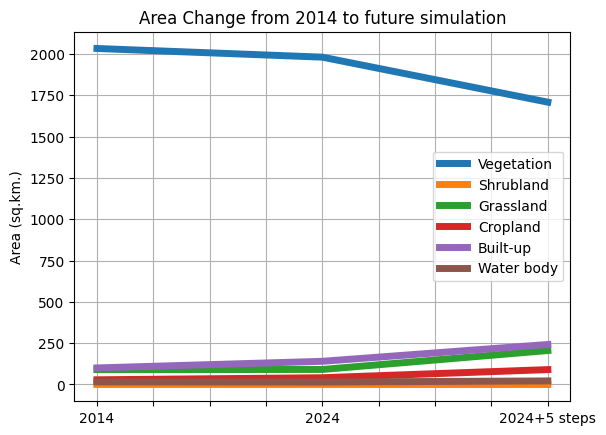

In [64]:
plt.figure(figsize=(8,5))

lulc_area_df.transpose().iloc[:-1, 1:].plot(lw=5)

plt.ylabel('Area (sq.km.)')

plt.title('Area Change from 2014 to future simulation')
plt.grid()

plt.show()

Or bar plot to see net gain from simulation

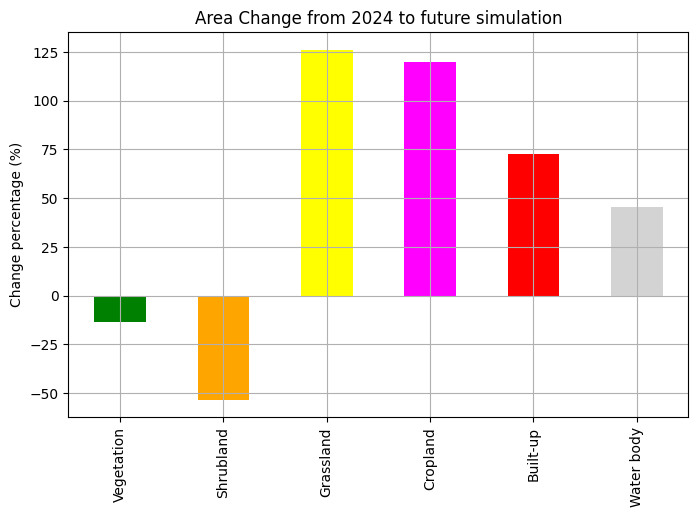

In [65]:
plt.figure(figsize=(8,5))

lulc_area_df.transpose().iloc[-1, 1:].plot.bar(lw=5, color=y_color[1:])

plt.ylabel('Change percentage (%)')

plt.title('Area Change from 2024 to future simulation')
plt.grid()

plt.show()


For more beauty of visualization, we can have these charts

In [66]:
#area_change = confusion_matrix(datacube_past_enc.flatten(), datacube_current_enc.flatten()) * 900 / 1_000_000

area_change = confusion_matrix(datacube_current_enc.flatten(), state_map.flatten()) * 900 / 1_000_000

#### Sankey plot

In [67]:
import plotly.graph_objects as go

# Sample confusion matrix
cm = area_change[1:, 1:]

# Prepare the Sankey plot data
source = []
target = []
value = []

for i in range(len(cm)):
    for j in range(len(cm[i])):
        source.append(i)
        target.append(len(cm) + j)
        value.append(cm[i][j])

# Create the Sankey plot
fig = go.Figure(
    data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=10,
        line=dict(color="black", width=0.5),
        label=labels[1:] + labels[1:],
        color="springgreen"
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ),
)])

fig.update_layout(title_text="Sankey Diagram for LULC Change", autosize=True, font_size=16, height=800, width=800)
fig.show()


#### Circlize chart

In [68]:
!pip install pycirclize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.2 MB/s eta 0:00:00


In [69]:
from pycirclize import Circos

matrix_df = pd.DataFrame(area_change[1:, 1:], index=labels[1:], columns=labels[1:])

# Initialize from matrix (Can also directly load tsv matrix file)
circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    r_lim=(93, 100),
    cmap="Pastel1",
    ticks_interval=500,
    label_kws=dict(r=94, size=12, color="black"),
)

circos.savefig("chord_diagram01.png")


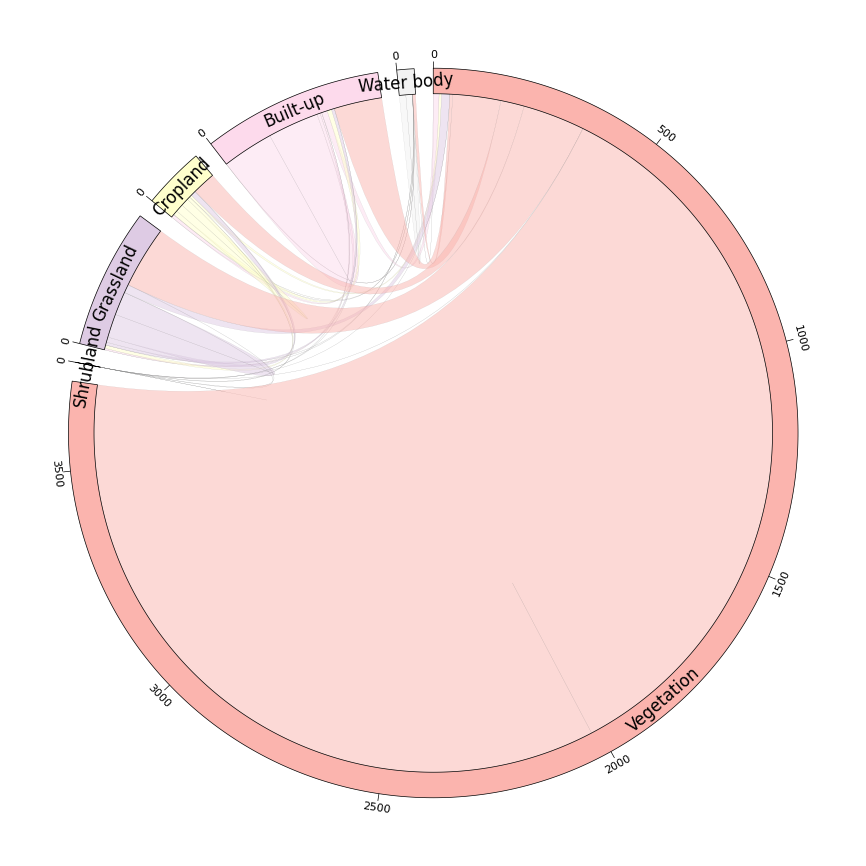

In [70]:
from IPython.display import Image
Image(filename="chord_diagram01.png")

#### Another Sankey

In [71]:
!pip install pysankey

<Figure size 500x500 with 0 Axes>

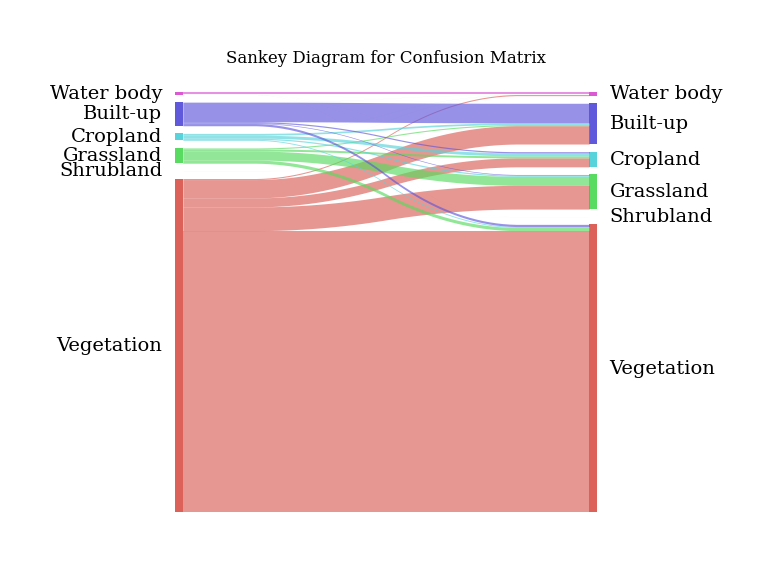

In [72]:
from pySankey.sankey import sankey

# Prepare the data for Sankey plot
data = []
for i in range(len(area_change[1:, 1:])):
    for j in range(len(area_change[1:, 1:][i])):
        if area_change[1:, 1:][i][j] > 0:
            data.append((labels[1:][i], labels[1:][j], area_change[1:, 1:][i][j]))

# Create a DataFrame
df = pd.DataFrame(data, columns=['source', 'target', 'value'])

# Create the Sankey plot
plt.figure(figsize=(5, 5))

sankey(left=df['source'], right=df['target'], leftWeight=df['value'], rightWeight=df['value'])

plt.title('Sankey Diagram for Confusion Matrix')

plt.show()
